In [1]:
import networkx as nx
import dwave_networkx as dnx
import random
import matplotlib.pyplot as plt
import numpy as np

# from lpSolver import solve
from uccgGenerator import tree_insertion, Graph
from plotNetwork import plotGraph, plotCoupling, plotGraphIS, INIT, FINAL, COMMON, NOTIN, in_current, plotSymmetricDiff
from networkx.algorithms.approximation import treewidth_min_fill_in
from networkx.algorithms.approximation.independent_set import maximum_independent_set

In [2]:
#! pip install dwave_networkx

In [3]:
def get_neighbors_of_status(g, u, status):
    return [v for v in g.neighbors(u) if g.nodes[v][status]]

In [4]:
def chordal_simplicial_generator(n, num_steps=10):
    g = nx.random_tree(n)
    num_steps = n * int(np.log2(n))
    print(num_steps)
    for i in range(num_steps):
        simplicial_vertices = filter(lambda v: dnx.is_simplicial(g, v), g.nodes)
        u = random.choice(list(simplicial_vertices))
        edges = list(g.edges(u))
        g.remove_edges_from(edges)
        g.remove_node(u)
        cliques = nx.chordal_graph_cliques(g)
        c = random.choice(list(cliques))
        g.add_edges_from([(u, v) for v in c])
        if i % 10 == 0:
            print(i)
    return g

In [5]:
def random_walk(g, lambd=1):
    u = random.sample(g.nodes, 1)[0]
    if g.nodes[u][in_current]:
        g.nodes[u][in_current] = False
    else:
        neighbors_in_current = get_neighbors_of_status(g, u, in_current)
        n = len(neighbors_in_current)
        if n >= 2:
            return
        if n == 1:
            v = neighbors_in_current[0]
            g.nodes[v][in_current] = False
        g.nodes[u][in_current] = True

In [6]:
def generate_pair(g1):
    n = len(g1)
    num_steps = 10 * n * int(np.log2(n))
    for u in g1.nodes:
        g1.nodes[u][in_current] = False
    print(num_steps)
    for _ in range(num_steps):
        random_walk(g1)
    g2 = nx.Graph(g1)
    for _ in range(num_steps):
        random_walk(g2)
    return g1, g2

In [7]:
def symmetric_diff(I, F):
    IF = nx.Graph(I)
    for u in IF:
        IF.nodes[u][INIT] = I.nodes[u][in_current] and not F.nodes[u][in_current]
        IF.nodes[u][FINAL] = F.nodes[u][in_current] and not I.nodes[u][in_current]
        IF.nodes[u][COMMON] = I.nodes[u][in_current] and F.nodes[u][in_current]
        IF.nodes[u][NOTIN] = not I.nodes[u][in_current] and not F.nodes[u][in_current]
    return IF

In [28]:
g = tree_insertion(20, 30)

In [29]:
figsize=(15, 15)

In [30]:
# g1, g2 = generate_pair(g)
# IF = symmetric_diff(g1, g2)
# plotSymmetricDiff(IF, figsize)

In [31]:
def random_walk_maximum(g):
    cg = nx.Graph(g)
    for _ in range(2000):
        nodes_in = [u for u in cg if cg.nodes[u][in_current]]
        u = random.choice(nodes_in)
        v = random.choice(list(cg.neighbors(u)))
        neighbors_in_is = [w for w in cg.neighbors(v) if cg.nodes[w][in_current]]
        if len(neighbors_in_is) != 1:
            continue
        cg.nodes[u][in_current] = False
        cg.nodes[v][in_current] = True
    return cg

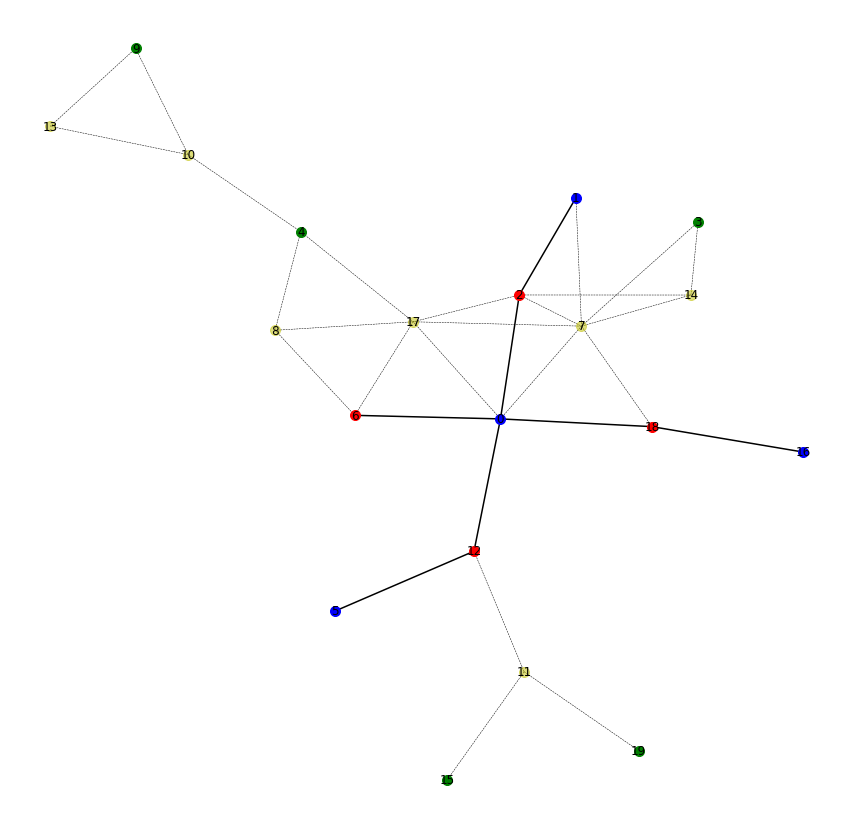

In [32]:
a = maximum_independent_set(g)
cg = nx.Graph(g)
for u in cg:
    cg.nodes[u][in_current] = False
for u in a:
    cg.nodes[u][in_current] = True
for u in cg:
    neighbors_in_is = [w for w in cg.neighbors(u) if cg.nodes[w][in_current]]
    if len(neighbors_in_is) == 0:
        cg.nodes[u][in_current] = True
cg2 = random_walk_maximum(cg)
IF = symmetric_diff(cg, cg2)
plotSymmetricDiff(IF, figsize)
plt.savefig('/Users/wenbosun/Desktop/ixorf.png', dpi=300, bbox_inches='tight', pad_inches=0)